# Team 6 Final Project
Chaim Gross, Eytan Slotnik, Tomer Fried, Naftali Arnold
## Week 6

 check correlation between cont_date and cont_doy and identifier of reporter

In [344]:
import pandas as pd
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import plotly.express as px
import numpy as np
import datetime
import seaborn as sns

# EDA

In [345]:
pd.set_option('display.max_columns', None)

In [346]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
raw_df = pd.read_sql_query("SELECT * from Fires", conn)
raw_df["STAT_CAUSE_CODE"] = raw_df["STAT_CAUSE_CODE"].astype(int)

In [347]:
X, y = raw_df.drop(columns = ["STAT_CAUSE_CODE"]), raw_df.filter(items = ["STAT_CAUSE_CODE"])

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

Let's investigate the data, using ProfileReport

In [349]:
df = X_train.merge(y_train, left_index=True, right_index=True)

In [350]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile.to_file("data_report.html")

After going through the data, we have chosen features that should be dropped based on:
- Many missing values
- High cardinality
- Features which provide data, that is already provided by other features
- Low correlation with any other feature
- Common sense for unnecessary features

In [351]:
columns_to_drop = ['OBJECTID', 'FOD_ID', 'FPA_ID', 'NWCG_REPORTING_UNIT_ID',
                   'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
                   'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME','COMPLEX_NAME', 'OWNER_CODE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', "Shape"]

df = df.drop(columns = columns_to_drop)

Points to think about from the EDA:
* New feature might be: length of fire. discovery minus contain. wh
* State feature - maybe we should do binning on high-cardinality values
* Most fires occur in specific fay of the year and specific time
* It seems like in different longitudes, the fires are common in different days of the year.
* Correlation stat_code and system_type should be checked
* Even though dropped, OWNER_CODE is highly correlated with other features and should be re-considered in the future.
* Maybe, interseting feature engineering can be done using  "NWCG_REPORTING_UNIT_ID", "FOD_ID"


# Missing Values

Let's check which features, out of the filtered ones, have missing values or "" values:

In [352]:
df.info()
(df == "").any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470116 entries, 138183 to 128037
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SOURCE_SYSTEM_TYPE     470116 non-null  object 
 1   SOURCE_SYSTEM          470116 non-null  object 
 2   NWCG_REPORTING_AGENCY  470116 non-null  object 
 3   FIRE_YEAR              470116 non-null  int64  
 4   DISCOVERY_DATE         470116 non-null  float64
 5   DISCOVERY_DOY          470116 non-null  int64  
 6   DISCOVERY_TIME         249395 non-null  object 
 7   STAT_CAUSE_DESCR       470116 non-null  object 
 8   CONT_DATE              247195 non-null  float64
 9   CONT_DOY               247195 non-null  float64
 10  CONT_TIME              227117 non-null  object 
 11  FIRE_SIZE              470116 non-null  float64
 12  FIRE_SIZE_CLASS        470116 non-null  object 
 13  LATITUDE               470116 non-null  float64
 14  LONGITUDE              470116 n

SOURCE_SYSTEM_TYPE       False
SOURCE_SYSTEM            False
NWCG_REPORTING_AGENCY    False
FIRE_YEAR                False
DISCOVERY_DATE           False
DISCOVERY_DOY            False
DISCOVERY_TIME           False
STAT_CAUSE_DESCR         False
CONT_DATE                False
CONT_DOY                 False
CONT_TIME                 True
FIRE_SIZE                False
FIRE_SIZE_CLASS          False
LATITUDE                 False
LONGITUDE                False
OWNER_DESCR              False
STATE                    False
STAT_CAUSE_CODE          False
dtype: bool

In [353]:
df["CONT_TIME"][df["CONT_TIME"] == ""] = None # There are entries in "CONT_TIME" with value "", so for the sake of unity, we fill it with None.

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\2484478842.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Features with missing values:
- DISCOVERY_TIME
- CONT_DATE
- CONT_DOY
- CONT_TIME

Their missing values are correlated with each other, along with "LOCAL_FRIE_REPORT_ID", "FIRE_CODE", "FIRE_NAME".
Let's take a look at the null values of them

In [354]:
discovery_time_missing = raw_df[raw_df["DISCOVERY_TIME"].isnull()].filter(items = ["DISCOVERY_TIME", "CONT_DATE", "CONT_DOY", "CONT_TIME", "LOCAL_FRIE_REPORT_ID" , "FIRE_CODE", "FIRE_NAME"])
discovery_time_missing

DISCOVERY_TIME  CONT_DATE  CONT_DOY CONT_TIME FIRE_CODE  \
0                None        NaN       NaN      None      None   
3                None        NaN       NaN      None      None   
4                None        NaN       NaN      None      None   
8                None        NaN       NaN      None      None   
10               None        NaN       NaN      None      None   
...               ...        ...       ...       ...       ...   
626808           None        NaN       NaN      None      None   
626809           None        NaN       NaN      None      None   
626811           None        NaN       NaN      None      None   
626820           None        NaN       NaN      None      None   
626821           None        NaN       NaN      None      None   

                        FIRE_NAME  
0                            None  
3                            None  
4                            None  
8                            None  
10                           None  
...                           ...  
626808  HWY 152  E/ RD 8           
626809                       None  
626811                       None  
626820  BRANCIFORTE DR  SOQUEL 5   
626821                       None  

[294076 rows x 6 columns]

In [355]:
cont_date_doy_missing = raw_df[raw_df["CONT_DATE"].isnull()].filter(items = ["LOCAL_FRIE_REPORT_ID", "CONT_DATE", "CONT_DOY", "CONT_TIME", "FIRE_CODE", "FIRE_NAME"])
cont_date_doy_missing


CONT_DATE  CONT_DOY CONT_TIME FIRE_CODE                  FIRE_NAME
0             NaN       NaN      None      None                       None
3             NaN       NaN      None      None                       None
4             NaN       NaN      None      None                       None
6             NaN       NaN      None      None                       None
7             NaN       NaN      None      None                       None
...           ...       ...       ...       ...                        ...
626809        NaN       NaN      None      None                       None
626811        NaN       NaN      None      None                       None
626814        NaN       NaN      None      None     MS0    0808-3310326003
626820        NaN       NaN      None      None  BRANCIFORTE DR  SOQUEL 5 
626821        NaN       NaN      None      None                       None

[297088 rows x 5 columns]

In [356]:
cont_time_missing = raw_df[raw_df["CONT_TIME"].isnull()].filter(items = ["CONT_TIME", "LOCAL_FRIE_REPORT_ID", "CONT_DATE", "CONT_DOY", "FIRE_CODE", "FIRE_NAME"])
cont_time_missing

CONT_TIME  CONT_DATE  CONT_DOY FIRE_CODE                  FIRE_NAME
0           None        NaN       NaN      None                       None
3           None        NaN       NaN      None                       None
4           None        NaN       NaN      None                       None
6           None        NaN       NaN      None                       None
7           None        NaN       NaN      None                       None
...          ...        ...       ...       ...                        ...
626809      None        NaN       NaN      None                       None
626811      None        NaN       NaN      None                       None
626814      None        NaN       NaN      None     MS0    0808-3310326003
626820      None        NaN       NaN      None  BRANCIFORTE DR  SOQUEL 5 
626821      None        NaN       NaN      None                       None

[323724 rows x 5 columns]

We can see that entries with null values at one feature, are also null in the others, mostly.

Let's do a histogram of "discovery date - contain_date" (differentiating each other)

In [357]:
no_missing = df.dropna()
px.histogram(df["CONT_DOY"] - df["DISCOVERY_DOY"])

we can see that The majority of the fires are contained in the same day, and after, in the day after it.
Therefore, we will impute the missing values of "CONT_DATE" with "DISCOVERY_DATE" and "CONT_DOY" with "DISCOVERY_DOY" (for now).

In [358]:
empty_indices = df['CONT_DOY'][df['CONT_DOY'].isna()].index
df.loc[:, 'CONT_DOY' ].loc[empty_indices] = df.loc[:,'DISCOVERY_DOY' ].loc[empty_indices]
df.loc[:, 'CONT_DATE'].loc[empty_indices] = df.loc[:,'DISCOVERY_DATE'].loc[empty_indices]
df.loc[:, 'CONT_TIME'].loc[empty_indices] = df.loc[:,'DISCOVERY_TIME'].loc[empty_indices]

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\1898532659.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\1898532659.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\1898532659.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Let's focus now on 'DISCOVERY_TIME', "CONT_TIME".
Maybe we can try to predict them using linear regression

In [359]:
features_with_missing = {'DISCOVERY_TIME' : None, "CONT_TIME" : None}
regression_features = ['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY']

for feature_name in features_with_missing:
    without_missing = df.loc[~df[feature_name].isnull()]
    without_missing[feature_name] = without_missing[feature_name].astype("float")
    X = without_missing.filter(items = regression_features)
    y = without_missing[feature_name]
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size = 0.25, random_state=0)
    regr = LinearRegression().fit(X_train_,y_train_)
    preds = regr.predict(X_test_)
    features_with_missing[feature_name] = pd.DataFrame({"y_test" : y_test_, "preds" : preds})

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\1695374835.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\1695374835.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



As we can see, the predicted values of "DISCOVERY_TIME" are between 14:00 - 15:00
and the predicted values of "CONT_TIME" are between 15:00 - 16:00

Options for imputing the missing values of "DISCOVERY_TIME" and "CONT_TIME":
    - impute them with mean value, without regression_features
    - impute with prediction from linear regression
    - dropping them out

Because we have approximately 300,000 missing values for every feature of them, mean imputing will be considered as a huge
bias. Also, it looks like linear regression predicts values which are close to the mean value.

Therefore, for now we will drop these features.

In [360]:
df = df.drop(columns=["DISCOVERY_TIME", "CONT_TIME"])

Next time work:
- Automatic One-hot encoding and label encoding
- Baseline model that works
- Manual One-hot encoding and label encoding
- complete missing values imputation

## Second thought, conversion, and dropping of features

Let's explore the categorical features and decide what to do with them:

In [361]:
categorical_features = df.select_dtypes(include=["object"])
for f in categorical_features.columns:
    print("\nValues:\n" + str(df[f].value_counts()) + "\n")


Values:
NONFED       340631
FED          119998
INTERAGCY      9487
Name: SOURCE_SYSTEM_TYPE, dtype: int64


Values:
ST-NASF        177686
DOI-WFMI        59857
FS-FIRESTAT     55257
ST-CACDF        21802
ST-NCNCS        16416
ST-GAGAS        16203
ST-MSMSS        15046
ST-TXTXS        14504
ST-ALALS        13901
ST-SCSCS        12209
ST-FLFLS        11236
IA-PRIITF        5522
FWS-FMIS         4884
ST-ORORS         4629
ST-LALAS         4072
ST-OKOKS         3927
ST-TNTNS         3701
ST-WIWIS         3641
ST-ARARS         2797
ST-VAVAS         2666
IA-HIWMO         2525
ST-MOMOS         2497
ST-WAWAS         2440
ST-MEMES         1834
ST-KYKYS         1629
ST-UTUTS         1091
ST-NMNMS         1066
IA-AKACC          919
ST-AZAZS          891
FA-NFIRS          863
ST-SDSDS          860
ST-CTCTS          857
ST-MTMTS          660
ST-COCOS          595
ST-MIMIS          532
IA-ICS209         521
ST-WYWYS          374
ST-NENES            6
Name: SOURCE_SYSTEM, dtype: int64


Values:
ST

One-Hot Encoding:
- STATE

Label Encoding:
- FIRE_SIZE_CLASS (might require some sort of transformation because on lonear)

Might be leakage, Dropping:
- SOURCE_SYSTEM
- NWCG_REPORTING_AGENCY
- STAT_CAUSE_DESCR
- SOURCE_SYSTEM_TYPE

Dropping:
- OWNER_DESCR


In [362]:
numeric_features = df.select_dtypes(include=[np.number])
for f in numeric_features.columns:
    print("\nValues:\n" + str(df[f].value_counts()) + "\n")


Values:
2006    28489
2000    24344
2007    23955
2011    22609
1999    22343
2005    22116
2001    21711
2008    21339
2010    20312
2009    19478
1996    18949
1994    18859
2002    18755
2015    18571
2012    18245
1995    17654
1998    17184
2003    17125
2004    17116
1992    17017
2014    16768
2013    16251
1993    15476
1997    15450
Name: FIRE_YEAR, dtype: int64


Values:
2454506.5    303
2455611.5    294
2453441.5    283
2453798.5    273
2456112.5    259
            ... 
2448999.5      1
2452259.5      1
2450807.5      1
2449001.5      1
2448951.5      1
Name: DISCOVERY_DATE, Length: 8760, dtype: int64


Values:
185    3159
186    2956
108    2386
101    2353
100    2295
       ... 
351     342
350     342
348     308
359     305
366     132
Name: DISCOVERY_DOY, Length: 366, dtype: int64


Values:
2454506.5    305
2455611.5    284
2453441.5    279
2453798.5    269
2453799.5    256
            ... 
2448999.5      1
2452259.5      1
2450783.5      1
2457388.5      1
2448951.5 

Dropping:
- DISCOVERY DATE - but to extract months, is weekend, is holiday
- DISCOVERY_DOY
- CONT_DOY - but to create feature of difference between discovery and contain day of year
- CONT_DATE
- FIRE_SIZE

One-Hot Encoding:
- months
- FIRE_YEAR

other notes:
- LATITUDE AND LONGITUDE might be problematic, but still usefull. Plus feature extraction might be usefull.



In [363]:
def create_date_faetures(df):
    """
    creates data features from YEAR and DOY.
    create a new column of date which is calculated from FIRE_YEAR and DISCOVERY_DOY, and extract from there features
    :param df: data
    :return: a new dataframe containing only the features we added
    """
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

    features = pd.DataFrame()
    df["DISCOVERY_DATE"] = pd.to_datetime(df['FIRE_YEAR'] * 1000 + df['DISCOVERY_DOY'], format='%Y%j')
    cal = calendar()

    # is holiday feature
    holidays = cal.holidays(start=df["DISCOVERY_DATE"].min(), end=df["DISCOVERY_DATE"].max())
    features['IS_HOLIDAY'] = df['DISCOVERY_DATE'].isin(holidays).astype(int)

    # is weekend feature
    features['IS_WEEKEND'] = dayofweek = df["DISCOVERY_DATE"].dt.dayofweek
    features['IS_WEEKEND'][dayofweek >= 5] = 1
    features['IS_WEEKEND'][dayofweek < 5]  = 0

    # month dummies
    month_dummies = pd.get_dummies(df["DISCOVERY_DATE"].dt.month, prefix="MONTH", drop_first=True)
    features = pd.concat([features, month_dummies], axis=1)

    return features

features = create_date_faetures(df)
df = df.merge(features, left_index=True, right_index=True)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\2889921300.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\2889921300.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [364]:
# Feature dropping
df = df.drop(columns=["OWNER_DESCR", "DISCOVERY_DATE", "DISCOVERY_DOY", "CONT_DOY", "CONT_DATE", "FIRE_SIZE",
                      "SOURCE_SYSTEM", "SOURCE_SYSTEM_TYPE", "NWCG_REPORTING_AGENCY", "STAT_CAUSE_DESCR"])

# One-Hot Encoding
for f in ['STATE', 'FIRE_YEAR']: # add months
    df = pd.get_dummies(df,prefix=[f], columns = [f], drop_first=True)

# Ordinal Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['FIRE_SIZE_CLASS'])
df['FIRE_SIZE_CLASS'] = le.transform(df['FIRE_SIZE_CLASS']) + 1

This is what we have got:

In [365]:
df.head()

FIRE_SIZE_CLASS   LATITUDE   LONGITUDE  STAT_CAUSE_CODE  IS_HOLIDAY  \
138183                2  31.248900  -93.176700                9           0   
519285                2  34.816700  -79.433300                9           0   
116246                2  38.697800 -112.172580               13           0   
179264                1  48.256667 -115.970000                1           0   
517587                2  33.218889 -117.128889                2           0   

        IS_WEEKEND  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  \
138183           0        1        0        0        0        0        0   
519285           0        1        0        0        0        0        0   
116246           0        0        0        0        0        0        1   
179264           0        0        0        0        0        0        0   
517587           0        0        0        0        0        0        1   

        MONTH_8  MONTH_9  MONTH_10  MONTH_11  MONTH_12  STATE_AL  STATE_AR  \
138183        0        0         0         0         0         0         0   
519285        0        0         0         0         0         0         0   
116246        0        0         0         0         0         0         0   
179264        1        0         0         0         0         0         0   
517587        0        0         0         0         0         0         0   

        STATE_AZ  STATE_CA  STATE_CO  STATE_CT  STATE_DC  STATE_DE  STATE_FL  \
138183         0         0         0         0         0         0         0   
519285         0         0         0         0         0         0         0   
116246         0         0         0         0         0         0         0   
179264         0         0         0         0         0         0         0   
517587         0         1         0         0         0         0         0   

        STATE_GA  STATE_HI  STATE_IA  STATE_ID  STATE_IL  STATE_IN  STATE_KS  \
138183         0         0         0         0         0         0         0   
519285         0         0         0         0         0         0         0   
116246         0         0         0         0         0         0         0   
179264         0         0         0         0         0         0         0   
517587         0         0         0         0         0         0         0   

        STATE_KY  STATE_LA  STATE_MA  STATE_MD  STATE_ME  STATE_MI  STATE_MN  \
138183         0         1         0         0         0         0         0   
519285         0         0         0         0         0         0         0   
116246         0         0         0         0         0         0         0   
179264         0         0         0         0         0         0         0   
517587         0         0         0         0         0         0         0   

        STATE_MO  STATE_MS  STATE_MT  STATE_NC  STATE_ND  STATE_NE  STATE_NH  \
138183         0         0         0         0         0         0         0   
519285         0         0         0         1         0         0         0   
116246         0         0         0         0         0         0         0   
179264         0         0         1         0         0         0         0   
517587         0         0         0         0         0         0         0   

        STATE_NJ  STATE_NM  STATE_NV  STATE_NY  STATE_OH  STATE_OK  STATE_OR  \
138183         0         0         0         0         0         0         0   
519285         0         0         0         0         0         0         0   
116246         0         0         0         0         0         0         0   
179264         0         0         0         0         0         0         0   
517587         0         0         0         0         0         0         0   

        STATE_PA  STATE_PR  STATE_RI  STATE_SC  STATE_SD  STATE_TN  STATE_TX  \
138183         0         0         0         0         0         0         0   
519285         0         0         0      

In [366]:
X_train, y_train = df.drop(columns = ["STAT_CAUSE_CODE"]), df.filter(items = ["STAT_CAUSE_CODE"])

## Next Time:
- Scaling and transformations on features
- Feature engineering and extraction
- Base model
- functionzing pre preprocessing for test data
- checking other things to do in shifter's notebooks


## Base Model, Scaling, and Geographic Feature Extraction

In order to fit and predict the test data, we need to create a function which pre-processes the test data,
the same way we did on the train data

In [367]:
def pre_process_data(data):
    features = create_date_faetures(data)
    data = data.merge(features, left_index=True, right_index=True)

    # One-Hot Encoding
    for f in ['STATE', 'FIRE_YEAR']: # add months
        data = pd.get_dummies(data,prefix=[f], columns = [f], drop_first=True)

    # Ordinal Encoding
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(data['FIRE_SIZE_CLASS'])
    data['FIRE_SIZE_CLASS'] = le.transform(data['FIRE_SIZE_CLASS']) + 1

    columns_to_drop = ['OBJECTID', 'FOD_ID', 'FPA_ID', 'NWCG_REPORTING_UNIT_ID',
               'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
               'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME','COMPLEX_NAME', 'OWNER_CODE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', "Shape", "DISCOVERY_TIME", "CONT_TIME",
               "OWNER_DESCR", "DISCOVERY_DATE", "DISCOVERY_DOY", "CONT_DOY", "CONT_DATE", "FIRE_SIZE",
                "SOURCE_SYSTEM", "SOURCE_SYSTEM_TYPE", "NWCG_REPORTING_AGENCY", "STAT_CAUSE_DESCR"]

    data = data.drop(columns = columns_to_drop)

    return data

X_test = pre_process_data(X_test)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\2889921300.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\2889921300.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Running the model on the test data

In [368]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest accuracy score is:")
print(accuracy_score(y_test,rf_preds))
print("Random Forest F1 score is:")
print(classification_report(y_test,rf_preds, zero_division=0))

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_20376\4112267117.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Random Forest accuracy score is:
0.5198716067029979
Random Forest F1 score is:
              precision    recall  f1-score   support

           1       0.69      0.78      0.74     23271
           2       0.30      0.25      0.27     12469
           3       0.13      0.06      0.08      4428
           4       0.34      0.25      0.29      6387
           5       0.50      0.59      0.54     35799
           6       0.41      0.36      0.39      2753
           7       0.49      0.48      0.48     23178
           8       0.22      0.13      0.17      5139
           9       0.46      0.46      0.46     26972
          10       0.44      0.37      0.40       994
          11       0.15      0.08      0.10      1177
          12       0.09      0.05      0.06       310
          13       0.82      0.81      0.81     13829

    accuracy                           0.52    156706
   macro avg       0.39      0.36      0.37    156706
weighted avg       0.50      0.52      0.51    156706



Wow! way more than we have expected. Is there a catch?
Let's check importance of the features

[('LONGITUDE', 0.31437201238699203),
 ('LATITUDE', 0.28807595300525823),
 ('FIRE_SIZE_CLASS', 0.03659344224695846),
 ('IS_WEEKEND', 0.02607642462895695),
 ('MONTH_8', 0.011397774963942035),
 ('MONTH_7', 0.011023453262191828),
 ('STATE_NY', 0.009445708817483885),
 ('FIRE_YEAR_2011', 0.009236927521652899),
 ('FIRE_YEAR_2007', 0.008735152854947012),
 ('FIRE_YEAR_2008', 0.008605674403094541),
 ('FIRE_YEAR_2010', 0.008082526529223519),
 ('FIRE_YEAR_2009', 0.00784273375569091),
 ('FIRE_YEAR_2005', 0.007652731073771009),
 ('FIRE_YEAR_2006', 0.00764420673329788),
 ('MONTH_4', 0.00762912153391597),
 ('STATE_GA', 0.007502617525400013),
 ('MONTH_6', 0.007243609407027807),
 ('FIRE_YEAR_1995', 0.007079736890806024),
 ('FIRE_YEAR_1996', 0.007068332950551874),
 ('FIRE_YEAR_2015', 0.0069241330924307365),
 ('FIRE_YEAR_2012', 0.006865294813550307),
 ('MONTH_5', 0.006851865629741252),
 ('FIRE_YEAR_1999', 0.006793707137145858),
 ('FIRE_YEAR_1994', 0.0067604676387580335),
 ('FIRE_YEAR_2000', 0.006731201659

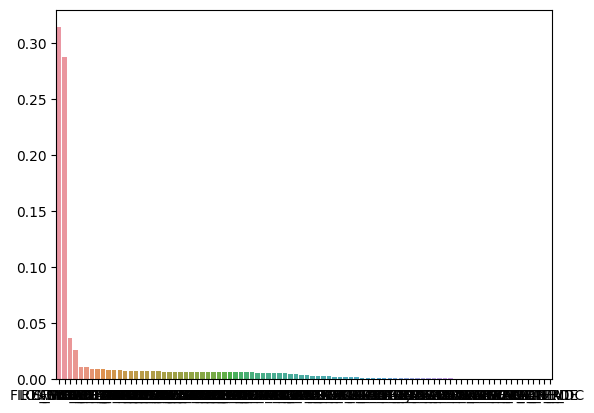

In [369]:
feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
sns.barplot(x=columns, y=importances)
feature_importances

As we can see:
- LATITUDE and LONGITUDE are significantly the most important features.

- after them, FIRE_SIZE_CLASS and IS_WEEKEND with much smaller importance

- STATE columns, FIRE_YEAR columns and IS_HOLIDAY have a very small importance for the prediction.
Same thing goes with MONTH columns, but they do have a little more importance: MONTH_7, MONTH_8.
The rest of the features are gradually decreasing in their importance.

General short code without EDA:


In [370]:
raw_df = pd.read_sql_query("SELECT * from Fires", conn)
raw_df["STAT_CAUSE_CODE"] = raw_df["STAT_CAUSE_CODE"].astype(int)
X, y = raw_df.drop(columns = ["STAT_CAUSE_CODE"]), raw_df.filter(items = ["STAT_CAUSE_CODE"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
df = X_train.merge(y_train, left_index=True, right_index=True)
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest accuracy score is:")
print(accuracy_score(y_test,rf_preds))
print("Random Forest F1 score is:")
print(classification_report(y_test,rf_preds, zero_division=0))

feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
sns.barplot(x=columns, y=importances)
feature_importances

## Next time:
- Try to balance STAT_CAUSE_CODE values
- Read online about location feature engineering
- Add a feature of weather at time and location of record